In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import os

%pylab inline

from IPython.display import Image
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#!curl https://github.com/fedhere/PUI2018_fb55/blob/master/HW11_fb55/MTA_Fare.npy?raw=true -o MTA_Fare.npy

In [3]:
#!mv MTA_Fare.npy $PUIDATA

In [4]:
mta = np.load(os.getenv("PUIDATA") + '/MTA_Fare.npy')

In [5]:
mta

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ...,
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [6]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [7]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [8]:
mta[24]

array([[46960, 53065, 54124, ..., 67125, 63465, 63833],
       [ 1307,  1399,  1394, ...,  2059,  1905,  1898],
       [  337,   399,   372, ...,   599,   575,   557],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [   -1,    -1,    -1, ...,  5288,  6704,  3716]], dtype=int32)

In [9]:
mta = mta.astype(float)
mta[mta == -1] = np.nan

In [10]:
dates = pd.date_range(start = '05/19/2010', periods = 194, freq = 'W')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,0.98,'Figure 1: MTA Metrocrard Swipes in Natural and Log Space')

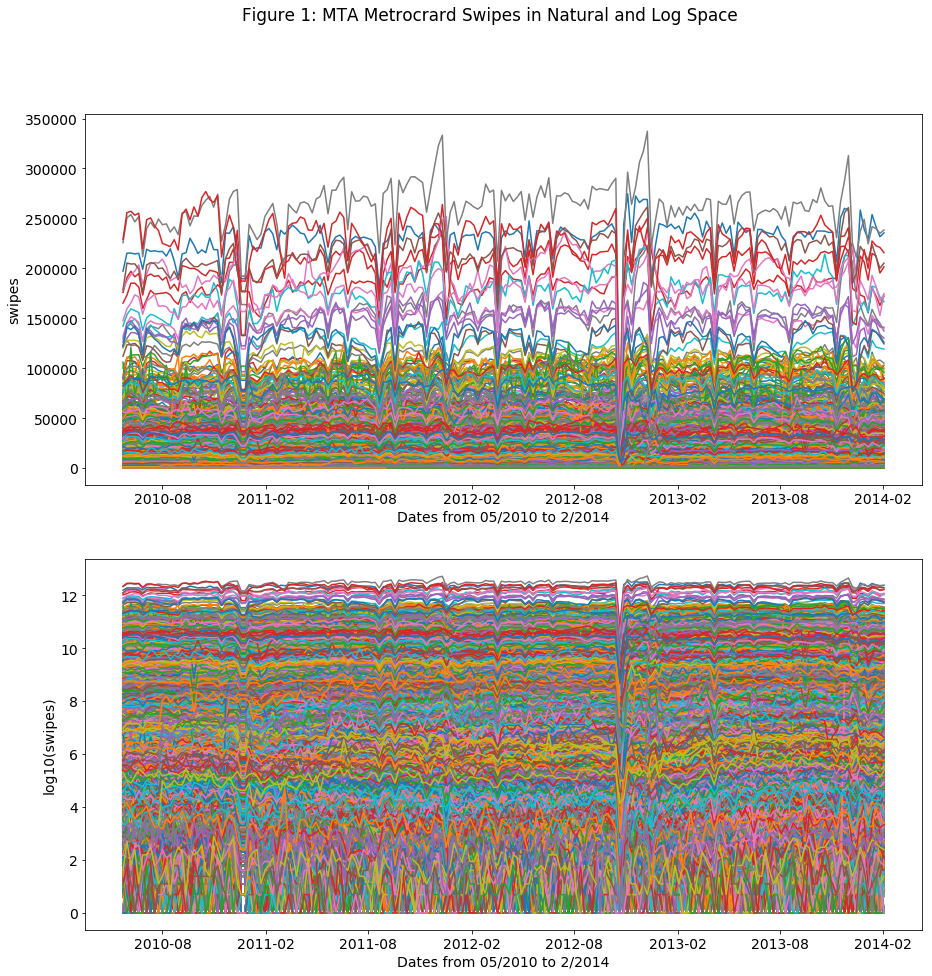

In [11]:
plt.rcParams.update({'font.size':14})
fig,(ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15,15))
ax1.set(xlabel = 'Dates from 05/2010 to 2/2014', ylabel = 'swipes')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax1.plot(dates,mta[i][j])
ax2.set(xlabel = 'Dates from 05/2010 to 2/2014', ylabel = 'log10(swipes)')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax2.plot(dates,np.log(mta[i][j]))
plt.suptitle('Figure 1: MTA Metrocrard Swipes in Natural and Log Space')

In [12]:
week_sum = np.nansum(np.nansum(mta, axis = 0), axis = 0)

In [13]:
print ("mean of MTA metrocard swipes{:.2f}".format(week_sum.mean()))
print ("stdev of MTA metrocard swipes {:.2f}".format(week_sum.std()))
thresholds = [week_sum.mean() + 3 * week_sum.std(), 
              week_sum.mean() - 3 * week_sum.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean of MTA metrocard swipes29781349.87
stdev of MTA metrocard swipes 2983960.42
3-sigma thresholds 38733231.14 20829468.61


In [14]:
event_index = np.where(week_sum < thresholds[1])
date_of_event = dates[event_index[0][0]+1]
print ("Date of event is", date_of_event)

Date of event is 2012-10-28 00:00:00


# Part 2

In [15]:
card_mean = np.nanmean(mta, axis  = 0)
card_df = pd.DataFrame(card_mean).T
card_df.columns = list(ridetype)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


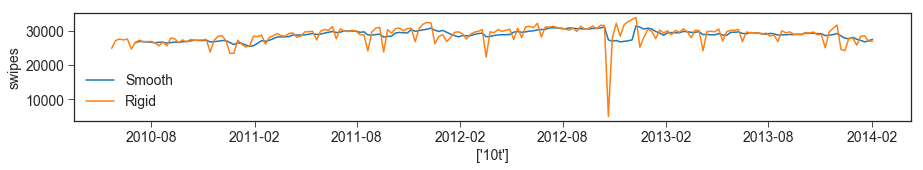

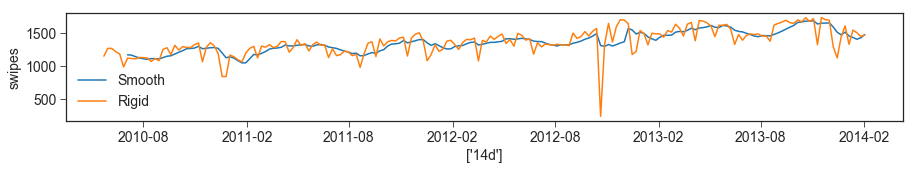

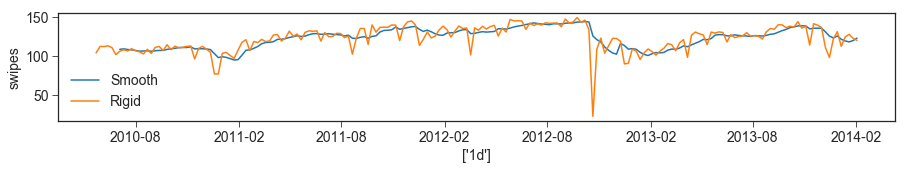

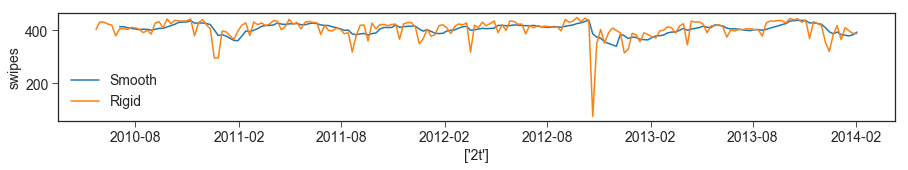

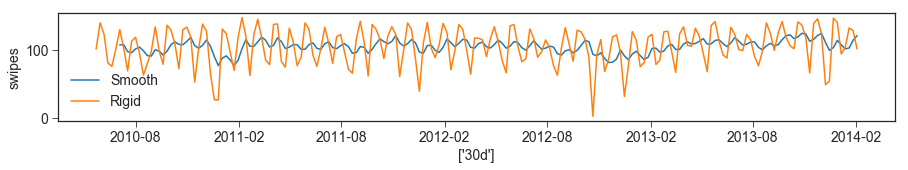

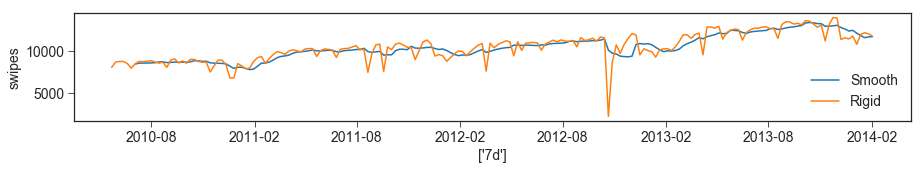

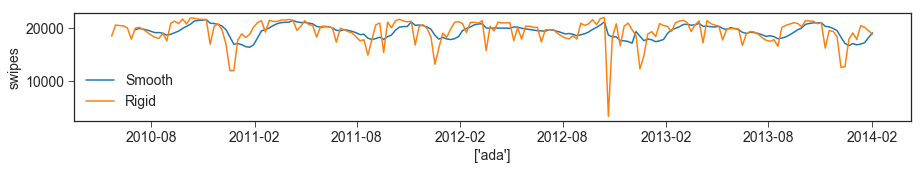

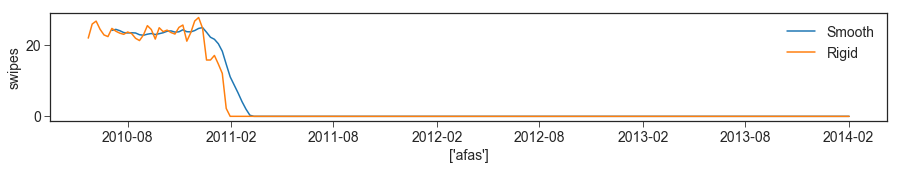

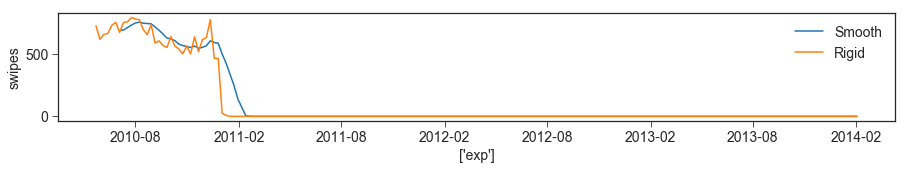

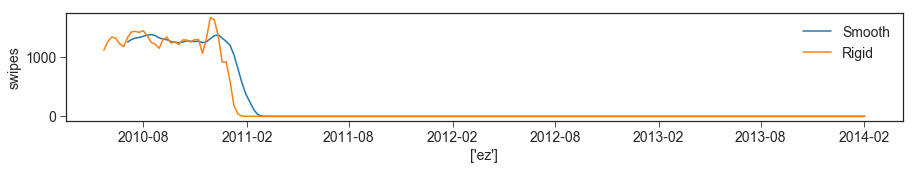

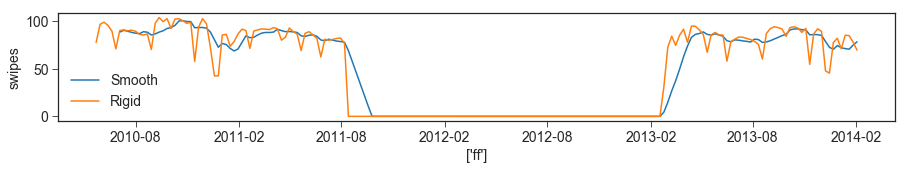

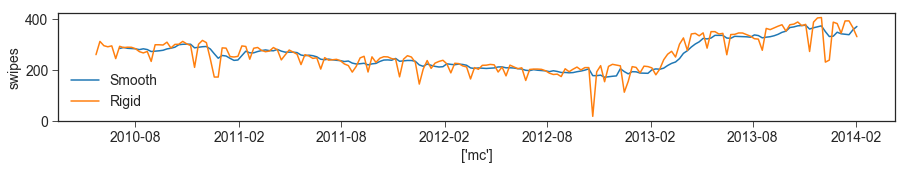

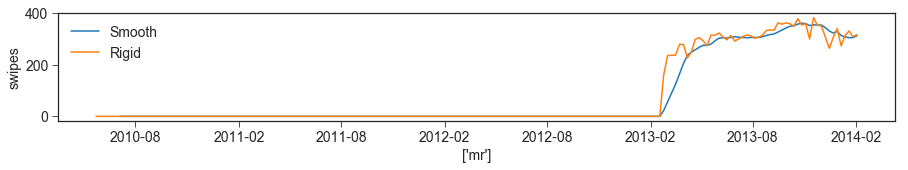

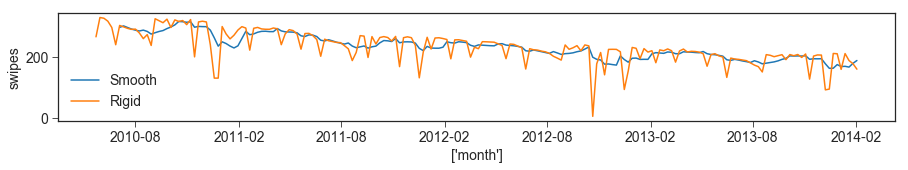

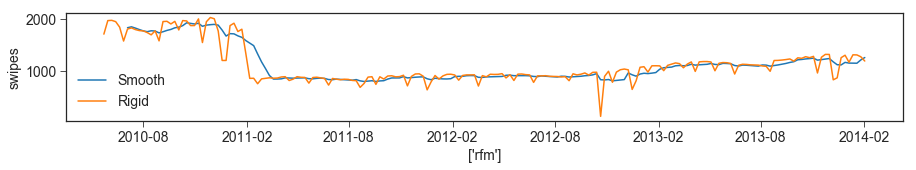

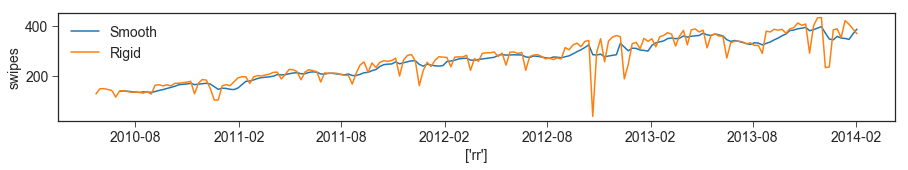

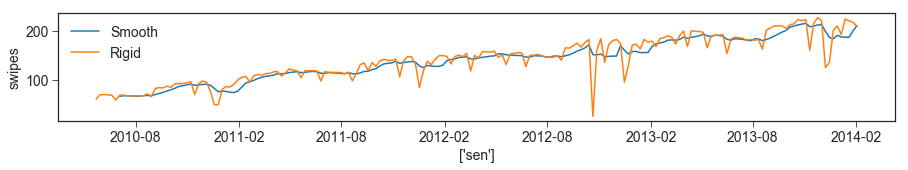

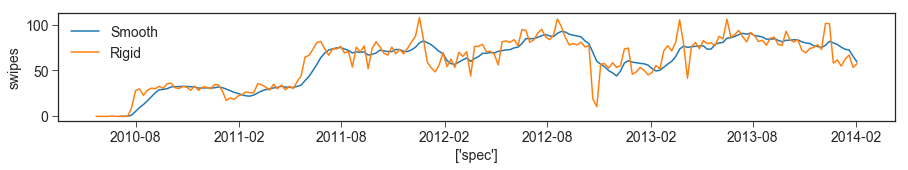

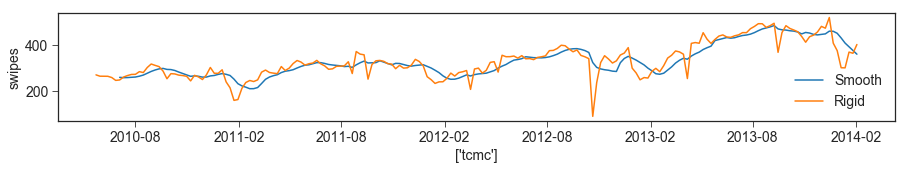

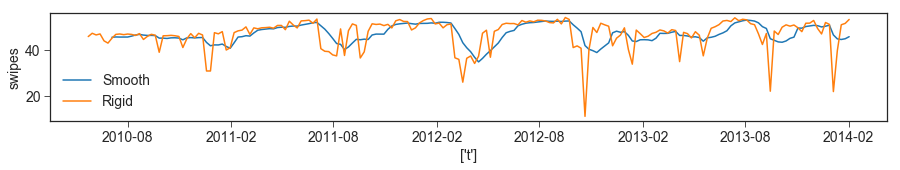

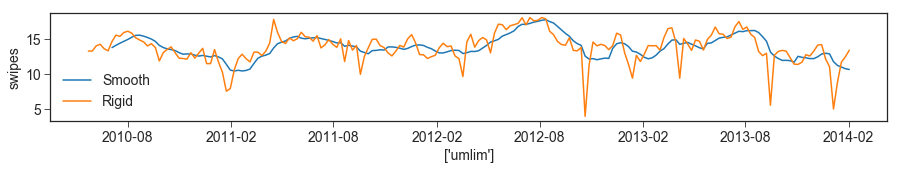

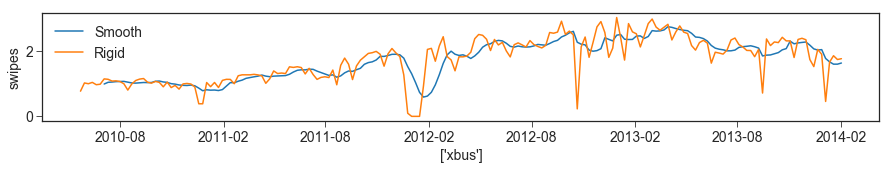

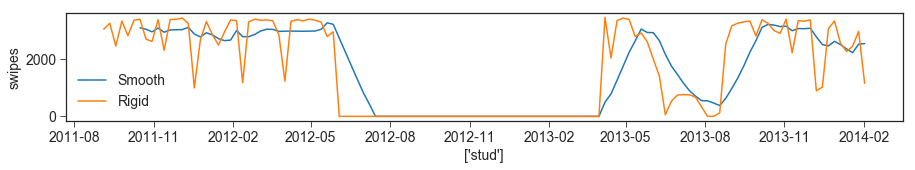

In [16]:
card_rollingmean = pd.DataFrame()
for type in ridetype:
    plt.style.use('seaborn-ticks')
    fig = plt.figure(figsize = (15,2))
    ax = fig.add_subplot(111)
    card_rollingmean[type] = card_df[type].rolling(7).mean()
    ax.plot(dates, card_rollingmean[type], label = 'Smooth')
    cols = ['{}'.format(type)]
    ax.plot(dates, card_df[type], label = 'Rigid')
    ax.set(xlabel = cols, ylabel = 'swipes')
    plt.legend()

In [17]:
#card_rollingmean.drop(columns = ['exp', 'afas', 'ez', 'ff', 'mr', 'stud', 'rfm'], inplace = True)
start = card_rollingmean[6:16].mean()
end = card_rollingmean[184:193].mean()
ratio = end/start
ratio.sort_values()

ez           0.000002
exp          0.000011
afas         0.000212
month        0.600946
rfm          0.653733
umlim        0.806683
ff           0.845389
ada          0.908481
2t           0.966752
10t          1.041786
t            1.045878
30d          1.091118
1d           1.159513
mc           1.229626
14d          1.329767
7d           1.428774
tcmc         1.612082
xbus         1.841295
rr           2.612024
sen          2.843863
spec         8.071897
mr       28362.536139
stud              NaN
dtype: float64

In [18]:
#Perform AS Fuller Test
ratio_updated = []
for type in ratio.index:
    ro = sm.tsa.adfuller(np.array(card_rollingmean[type].dropna()))[1]
    print('{},{}'.format(type, round(ro, 4)))


10t,0.2932
14d,0.8273
1d,0.1858
2t,0.0334
30d,0.4356
7d,0.6929
ada,0.0059
afas,0.0045
exp,0.0022
ez,0.0027
ff,0.3006
mc,0.8476
mr,0.975
month,0.5019
rfm,0.0075
rr,0.8696
sen,0.8504
spec,0.2737
tcmc,0.2401
t,0.0002
umlim,0.0116
xbus,0.5602
stud,0.314


# Part 3

In [251]:
#Reshape the mta matrix
new_reshape = mta.reshape(600*23, 194)

In [252]:
#Put that reshaped matrix in a dataframe
new_mta = pd.DataFrame(new_reshape)

In [253]:
#Visualize
new_mta.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,43608.0,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,1425.0,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,217.0,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,576.0,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,290.0,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0


In [254]:
#Create the card type labels for all 600 stations
new_mta['label'] = pd.Series(range(23)*600)

In [255]:
#Visualize
new_mta.head()

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,label
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,0
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0,1
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0,2
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0,3
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0,4


In [257]:
new_mta['mean'] = new_mta.mean(axis = 1)
new_mta['std'] = new_mta.std(axis = 1)
new_mta.head()

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,label,mean,std
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,0,58283.326425,18207.534955
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0,1,1818.715026,526.252729
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,194.0,183.0,185.0,200.0,186.0,167.0,167.0,2,236.103627,68.476081
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,517.0,593.0,498.0,538.0,545.0,516.0,489.0,3,733.849741,194.033391
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,349.0,357.0,197.0,220.0,281.0,309.0,245.0,4,291.642487,141.984571


In [266]:
stationmean = np.nanmean(mta,axis = (1,2))
stationmean.shape

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(600,)

In [269]:
stationstd = np.nanstd(mta,axis = (1,2))
stationstd.shape

(600,)

In [275]:
mta_cleaned = new_mta.dropna()
mta_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,label,mean,std,global_mean
46,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,0,3515.321025,511.647881,5238.507189
47,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,204.0,166.0,191.0,212.0,209.0,211.0,1,143.347574,45.119342,5238.507189
48,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,19.0,13.0,19.0,26.0,20.0,22.0,2,17.807163,8.203620,5238.507189
49,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,25.0,29.0,31.0,28.0,24.0,22.0,3,30.015582,10.053124,5238.507189
50,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,8.0,6.0,5.0,5.0,6.0,0.0,4,2.909262,4.215414,5238.507189


In [ ]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")
Out[25]:
